In [1]:
from optparse import OptionParser
import json
import os
import pickle
import random
import re
import pandas as pd
import pysam
import h5py
import numpy as np

import matplotlib.pyplot as plt
from cooltools.lib.numutils import set_diag
from scipy.stats import spearmanr, pearsonr

/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numutils.py:652: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_correction_symmetric(
/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numutils.py:727: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_co

In [2]:
# import tensorrt as trt (if installed, it's not used by Akita anyways)
import tensorflow as tf
from basenji import seqnn, stream, dataset, dna_io
from akita_utils.utils import ut_dense

2024-04-22 14:20:01.642287: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 14:20:01.642345: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 14:20:01.643123: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-22 14:20:01.648493: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 14:20:02.808995: W tensorflow/compiler/tf2

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' ### run on CPU
print(tf.config.list_physical_devices('GPU'))

[]


In [4]:
main_dir = "/project/fudenber_735/tensorflow_models/akita/v1/"
model_file = main_dir + "model_best.h5"
params_file = main_dir + "params.json"

In [5]:
### load params, specify model ###

with open(params_file) as params_open:
    params = json.load(params_open)
    params_model = params['model']
    params_train = params['train']

seqnn_model = seqnn.SeqNN(params_model)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence (InputLayer)       [(None, 1048576, 4)]         0         []                            
                                                                                                  
 stochastic_reverse_complem  ((None, 1048576, 4),         0         ['sequence[0][0]']            
 ent (StochasticReverseComp   ())                                                                 
 lement)                                                                                          
                                                                                                  
 stochastic_shift (Stochast  (None, 1048576, 4)           0         ['stochastic_reverse_complemen
 icShift)                                                           t[0][0]']               

In [6]:
### restore model ###
# note: run %%bash get_model.sh 
# if you have not already downloaded the model
seqnn_model.restore(model_file)
print('successfully loaded')

successfully loaded


In [7]:
### names of targets ###
data_dir = main_dir + "data/"

hic_targets = pd.read_csv(data_dir+'/targets.txt',sep='\t')
hic_file_dict_num = dict(zip(hic_targets['index'].values, hic_targets['file'].values) )
hic_file_dict     = dict(zip(hic_targets['identifier'].values, hic_targets['file'].values) )
hic_num_to_name_dict = dict(zip(hic_targets['index'].values, hic_targets['identifier'].values) )

# read data parameters
data_stats_file = '%s/statistics.json' % data_dir
with open(data_stats_file) as data_stats_open:
    data_stats = json.load(data_stats_open)
seq_length = data_stats['seq_length']
target_length = data_stats['target_length']
hic_diags =  data_stats['diagonal_offset']
target_crop = data_stats['crop_bp'] // data_stats['pool_width']
target_length1 = data_stats['seq_length'] // data_stats['pool_width']

## Make predictions for saved tfrecords

In [8]:
v1_data_split_path = "/project/fudenber_735/tensorflow_models/akita/v1/data/sequences.bed"

In [9]:
all_test_V1_seqs = pd.read_csv(v1_data_split_path, sep='\t', names=['chr','start','stop','type'])
all_test_V1_seqs = all_test_V1_seqs.iloc[all_test_V1_seqs['type'].values=='test']

In [10]:
overlap_test = pd.read_csv("./data/v1_v2_sequences.tsv", sep='\t')

In [11]:
# reading inputs and targets
data_dir_v1 = "/project/fudenber_735/tensorflow_models/akita/v1/data/"
test_data_v1 = dataset.SeqDataset(data_dir_v1, 'test', batch_size=8)
test_inputs, test_targets = test_data_v1.numpy(return_inputs=True, return_outputs=True)

In [ ]:
# pearson R across the full text set (413 test sequences)
# pearR = pearsonr(seqnn_model.model.predict(test_inputs[:,:,:]).flatten(), test_targets[:,:,:].flatten())

In [ ]:
# pearR[0]

In [12]:
test_MSE = []
test_Spearman = []

all_preds = []
all_targets = []

In [13]:
from akita_utils.stats_utils import plot_map

In [14]:
for ind, row in overlap_test.iterrows():
    if ind % 10 == 0:
        print(f"Index: {ind}")
    chr, seq_start, seq_end = row.chr, row.start, row.stop
    myseq_str = chr+':'+str(seq_start)+'-'+str(seq_end)
    print("\t - ", myseq_str)

    # find index in the all test sequences
    index = np.where( (all_test_V1_seqs['chr'].values== chr) *
                         (all_test_V1_seqs['start'].values== int(seq_start))*
                         (all_test_V1_seqs['stop'].values==  int(seq_end))  )[0][0] 

    test_target = test_targets[index:index+1,:,:]
    test_pred = seqnn_model.model.predict(test_inputs[index:index+1,:,:])

    all_targets.append(test_target[0,:,:])
    all_preds.append(test_pred[0,:,:])
    
    # test_target_maps = ut_dense(test_target[0,:,:])
    # test_pred_maps = ut_dense(test_pred[0,:,:])

    # print("target: ")
    # plot_map(test_target_maps[:,:,0])
    # print("prediction: ")
    # plot_map(test_pred_maps[:,:,0])
    
    MSE = [np.mean((test_target[0,:,target_index] - test_pred[0,:,target_index]) ** 2) for target_index in range(test_pred.shape[2])]
    test_MSE.append(MSE)

    spearman = [spearmanr(test_pred[0,:,target_index], test_target[0,:,target_index])[0] for target_index in range(test_pred.shape[2])]
    test_Spearman.append(spearman)
    
    print()

Index: 0
	 -  chr1:72345600-73394176
1/1 [==============================] - 1s 1s/step

	 -  chr1:72869888-73918464
1/1 [==============================] - 0s 431ms/step

	 -  chr1:73394176-74442752
1/1 [==============================] - 0s 426ms/step

	 -  chr1:73918464-74967040
1/1 [==============================] - 0s 426ms/step

	 -  chr1:74442752-75491328
1/1 [==============================] - 0s 430ms/step

	 -  chr1:74967040-76015616
1/1 [==============================] - 0s 426ms/step

	 -  chr1:75491328-76539904
1/1 [==============================] - 0s 437ms/step

	 -  chr1:76015616-77064192
1/1 [==============================] - 0s 441ms/step

	 -  chr1:76539904-77588480
1/1 [==============================] - 0s 450ms/step

	 -  chr1:109703168-110751744
1/1 [==============================] - 0s 436ms/step

Index: 10
	 -  chr1:110227456-111276032
1/1 [==============================] - 0s 436ms/step

	 -  chr1:110751744-111800320
1/1 [==============================] - 0s 432ms/

In [15]:
overlap_test = overlap_test.copy()

test_MSE_array = np.array(test_MSE)
test_Spearman_array = np.array(test_Spearman)

for target_index in range(5):
    overlap_test.loc[:, f"v1_MSE_{target_index}"] = test_MSE_array[:, target_index]
    overlap_test.loc[:, f"v1_S_{target_index}"] = test_Spearman_array[:, target_index]

In [16]:
# Now perform your operation
overlap_test.loc[:, 'v1_MSE'] = overlap_test[[f"v1_MSE_{target_index}" for target_index in range(5)]].mean(axis=1)
overlap_test.loc[:, 'v1_S'] = overlap_test[[f"v1_S_{target_index}" for target_index in range(5)]].mean(axis=1)

In [ ]:
# overlap_test.to_csv("v1_results.tsv", sep="\t", index=False, header=True)

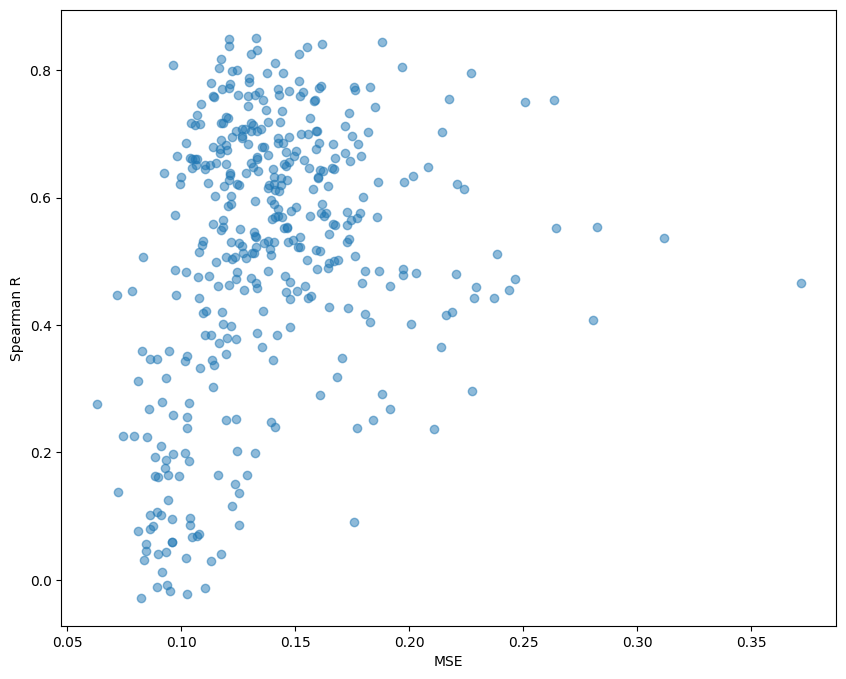

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(overlap_test["v1_MSE"], overlap_test["v1_S"], alpha=0.5)

ax.set_xlabel("MSE")
ax.set_ylabel("Spearman R")

plt.show()

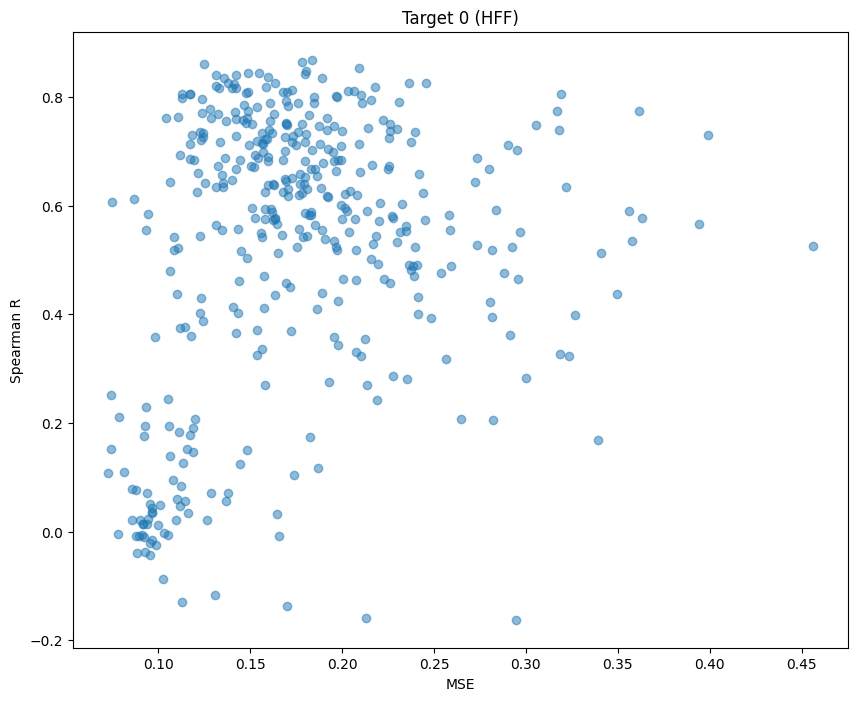

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(overlap_test["v1_MSE_0"], overlap_test["v1_S_0"], alpha=0.5)

ax.set_xlabel("MSE")
ax.set_ylabel("Spearman R")

ax.set_title("Target 0 (HFF)")

plt.show()

## Pearson Correlation

In [19]:
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

In [20]:
pearR = pearsonr(all_preds.flatten(), all_targets.flatten())

In [21]:
pearR

PearsonRResult(statistic=0.6203657074150916, pvalue=0.0)

In [23]:
spearmanR = spearmanr(all_preds.flatten(), all_targets.flatten())

In [24]:
spearmanR

SignificanceResult(statistic=0.5605090978543228, pvalue=0.0)

In [28]:
mse = ((all_targets.flatten() - all_preds.flatten()) ** 2).mean()

In [29]:
mse

0.13908249

## Plotting Maps

In [ ]:
# very close to diagonal -> chr1:73918464-74967040
# better performance -> chr9:132390912-133439488

In [30]:
fig_examples = [   'chr1:73918464-74967040',
                    'chr9:132390912-133439488']
fig_inds = []
for seq in fig_examples:
    print(seq)
    chrm,start,stop = seq.split(':')[0], seq.split(':')[1].split('-')[0], seq.split(':')[1].split('-')[1]
    test_ind = np.where( (all_test_V1_seqs['chr'].values== chrm) *
                         (all_test_V1_seqs['start'].values== int(start))*
                         (all_test_V1_seqs['stop'].values==  int(stop ))  )[0][0]
    fig_inds.append(test_ind)
fig_inds

chr1:73918464-74967040
chr9:132390912-133439488


[84, 263]

In [31]:
from akita_utils.stats_utils import plot_map

 
chr1:73918464-74967040
1/1 [==============================] - 0s 447ms/step
(448, 448, 5)
(448, 448, 5)
target: 


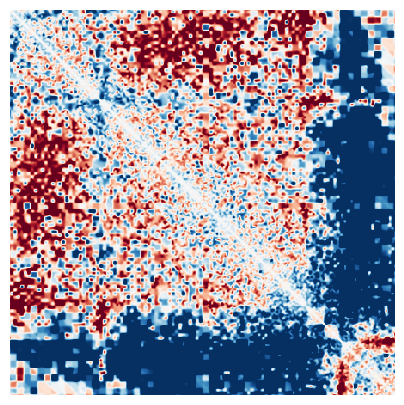

prediction: 


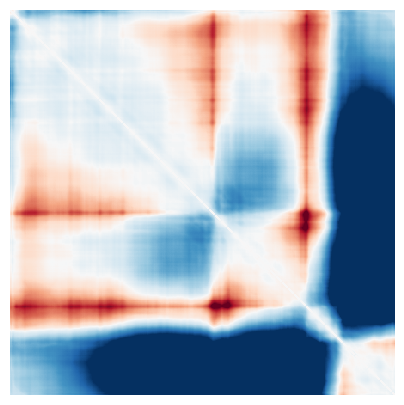

 
chr9:132390912-133439488
1/1 [==============================] - 0s 434ms/step
(448, 448, 5)
(448, 448, 5)
target: 


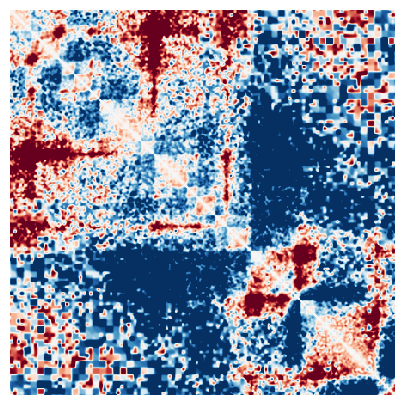

prediction: 


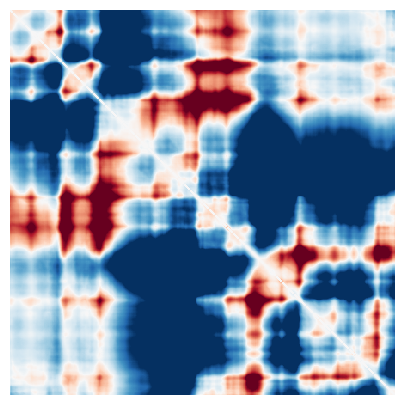

In [32]:
## make predictions and plot the three examples above ###

for test_index in fig_inds:
    chrm, seq_start, seq_end = all_test_V1_seqs.iloc[test_index][0:3]
    myseq_str = chrm+':'+str(seq_start)+'-'+str(seq_end)
    print(' ')
    print(myseq_str)
    
    test_target = test_targets[test_index:test_index+1,:,:]
    test_pred = seqnn_model.model.predict(test_inputs[test_index:test_index+1,:,:])

    test_target_maps = ut_dense(test_target[0,:,:])
    test_pred_maps = ut_dense(test_pred[0,:,:])

    print(test_target_maps.shape)
    print(test_pred_maps.shape)

    # # maps averaged over all targets
    # ave_test_target_maps = np.mean(test_target_maps, axis=2)
    # ave_test_pred_maps = np.mean(test_pred_maps, axis=2)

    # target to save
    target_index = 0
    
    # # saving TMP targets
    # np.savez(f'TMP_target_{myseq_str}_map_v1.npz', target=ave_test_target_maps)
    
    # saving prediction
    np.savez(f'./matrices/{myseq_str}_map_v1_tg0.npz', prediction=test_pred_maps[:,:,target_index])
    
    # print("target: ")
    # plot_map(ave_test_target_maps) #vmin=-2, vmax=2)
    # print("prediction: ")
    # plot_map(ave_test_pred_maps) #vmin=-2, vmax=2)

    print("target: ")
    plot_map(test_target_maps[:,:,target_index])
    print("prediction: ")
    plot_map(test_pred_maps[:,:,target_index])